In [2]:
from ema_workbench import (
    ScalarOutcome,
    load_results
)

from ema_workbench.util import ema_logging
from ema_workbench.analysis import parcoords

import pareto
import pandas as pd
import numpy as np
from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
robustness_results = load_results('./output/robustness_experiment_results.tar.gz')
experiments, outcomes = robustness_results

In [4]:
# Separate results according to which Scenario the Policy was originally generated for
experiments['Original Scenario'] = ''
for idx, row in experiments.iterrows():
    experiments.at[idx, 'Original Scenario'] = row.policy.split('_')[0][1:]

In [33]:
experiments_by_scenario = {}
outcomes_by_scenario = {}
scenarios = np.unique(experiments['Original Scenario'])
for scenario in scenarios:
    experiments_by_scenario[scenario] = experiments[experiments['Original Scenario'] == scenario]

    indices = list(experiments_by_scenario[scenario].index)

    outcomes_by_scenario[scenario] = {}
    for key, array in outcomes.items():
        outcomes_by_scenario[scenario][key] = []

        for i in indices:
            outcomes_by_scenario[scenario][key].append(array[i])

----------

## Signal to Noise Ratio


In [6]:
# function to calculate SnS metric
def snr(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MINIMIZE:
        return mean*std
    else:
        return mean/std

In [7]:
outcome_epsilons = [100, 0.01, 100, 100, 0.01]
outcome_columns = [0, 1, 2, 3, 4]
outcomes_of_interest = ['A4_Expected_Annual_Damage', 'A4_Expected_Number_of_Deaths',
                        'Total_Expected_Annual_Damage', 'Total_Expected_Number_of_Deaths',
                        'Total_Infrastructure_Costs']

In [8]:
model, steps = get_model_for_problem_formulation('A4 Only')

In [14]:
snr_scores = {}
for scenario in scenarios:
    experiment_snr_scores = {}
    for policy in experiments_by_scenario[scenario]['policy']:
        scores = {}
        
        logical = experiments['policy']==policy
        
        for outcome in model.outcomes:
            if(outcome.name in outcomes_of_interest):
                value  = outcomes[outcome.name][logical]
                sn_ratio = snr(value, outcome.kind)
                scores[outcome.name] = sn_ratio
        experiment_snr_scores[policy] = scores
    df = pd.DataFrame.from_dict(experiment_snr_scores).T
    snr_scores[scenario] = df

snr_scores[scenarios[0]].head(3)

,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
s54840_p74,4.526318e+13,1.232083e-07,0.315831,1.564667e+18,0.025815
s54840_p29,8.224101e+12,2.372459e-08,0.000000,9.272904e+17,0.022542
s54840_p66,4.230448e+12,1.373347e-08,4.593787,5.097826e+17,0.009232


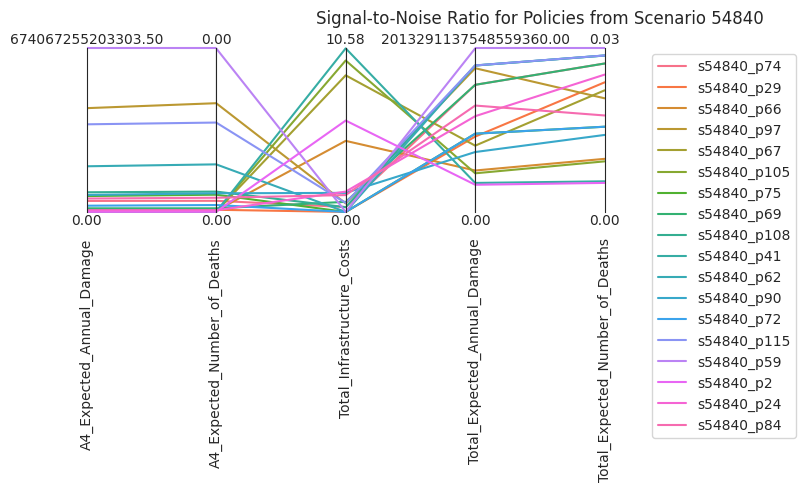

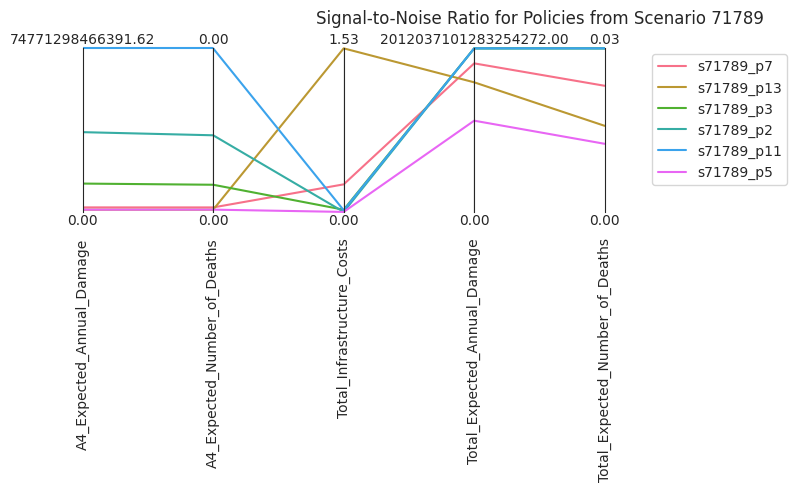

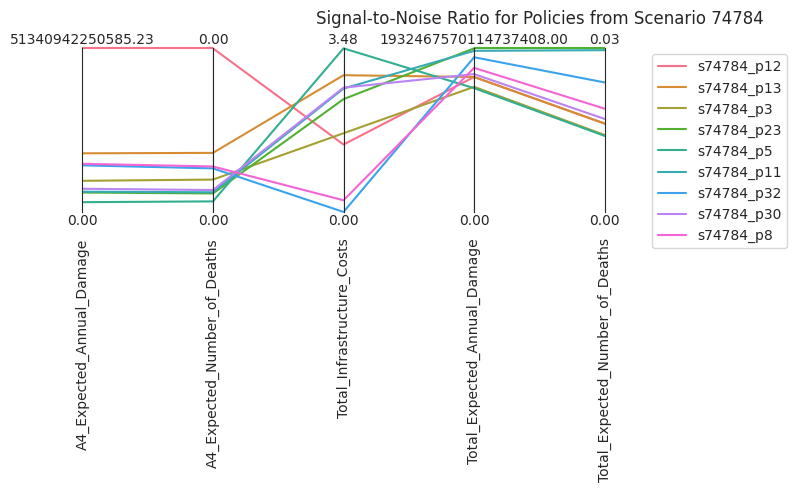

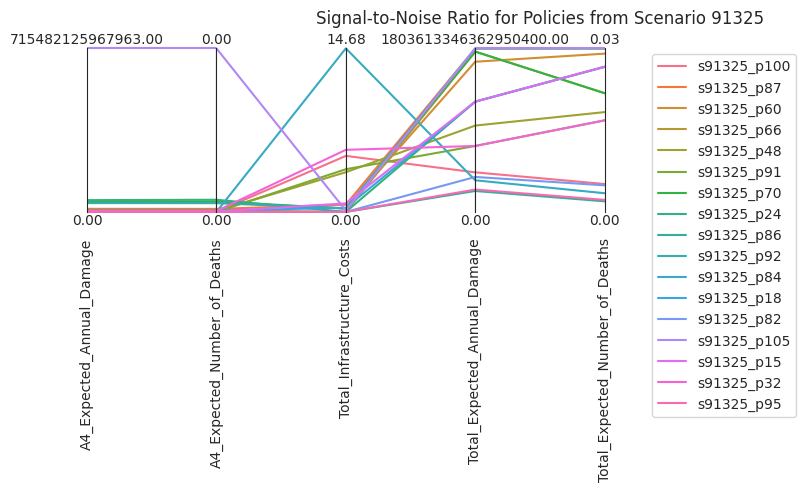

In [19]:
for scenario in scenarios:
        
    data = snr_scores[scenario]

    limits = parcoords.get_limits(data)
    limits.loc[0, outcomes_of_interest] = 0

    # sns.color_palette() has 10 colors.
    colors = sns.color_palette("husl", data.shape[0])
    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    #TODO: maybe enable printing the legend
    paraxes.legend()
    plt.title(f'Signal-to-Noise Ratio for Policies from Scenario {scenario}')
    plt.show()

In [26]:
# Pareto filtering
nondominated_policies = {}
for scenario in scenarios:
    scores_df = snr_scores[scenario]
    scores_df['Policy Name'] = scores_df.index
    nondominated_snr = pareto.eps_sort([list(scores_df.itertuples(False))],
                                        objectives=outcome_columns,
                                        epsilons=outcome_epsilons)
    # nondominated_snr_df = pd.DataFrame(columns=list(scores_df.columns))
 
    nondominated_policies[scenario] = []

    for row in nondominated_snr:
        nondominated_policies[scenario].append(row[-1])
    #     nondominated_snr_df.loc[len(nondominated_snr_df)] = row
        
    # for policy in nondominated_snr
    # nondominated_snr_df
    print(f'Scenario {scenario} has {len(nondominated_snr)} policies left.')

Scenario 54840 has 2 policies left.
Scenario 71789 has 2 policies left.
Scenario 74784 has 1 policies left.
Scenario 91325 has 2 policies left.


In [45]:
for scenario in scenarios:
    print(nondominated_policies[scenario])

['s54840_p41', 's54840_p2']
['s71789_p13', 's71789_p5']
['s74784_p5']
['s91325_p86', 's91325_p84']


---------------------

## Maximum Regret

In [ ]:
# helper function to calculate regret
def calculate_regret(data, best):
    return np.abs(best-data)

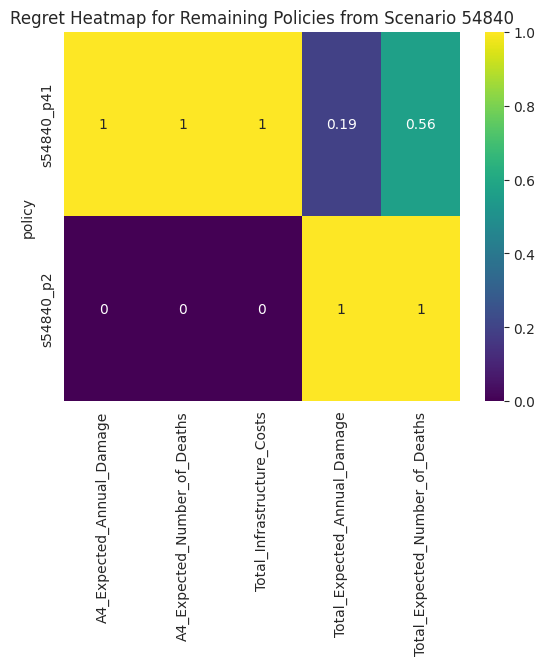

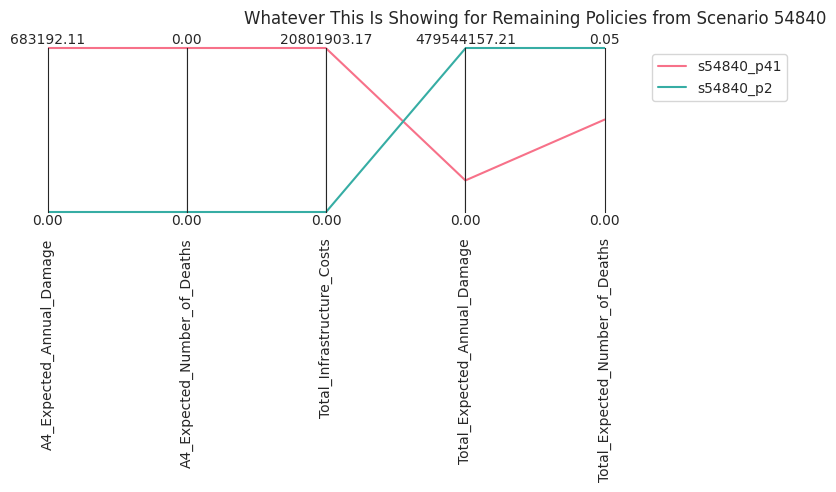

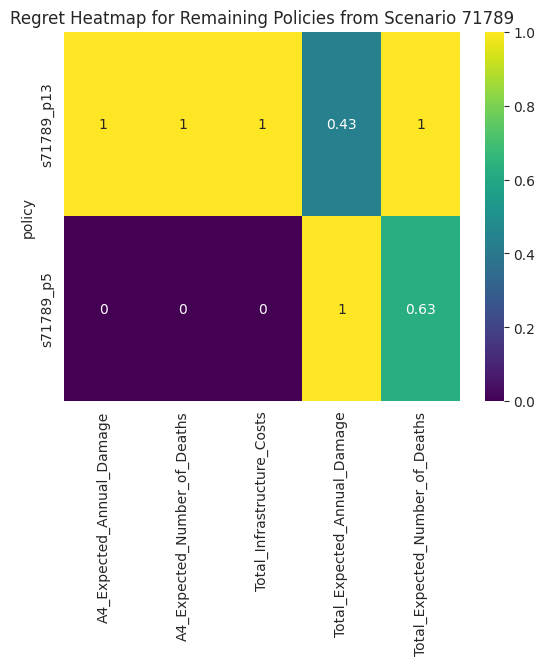

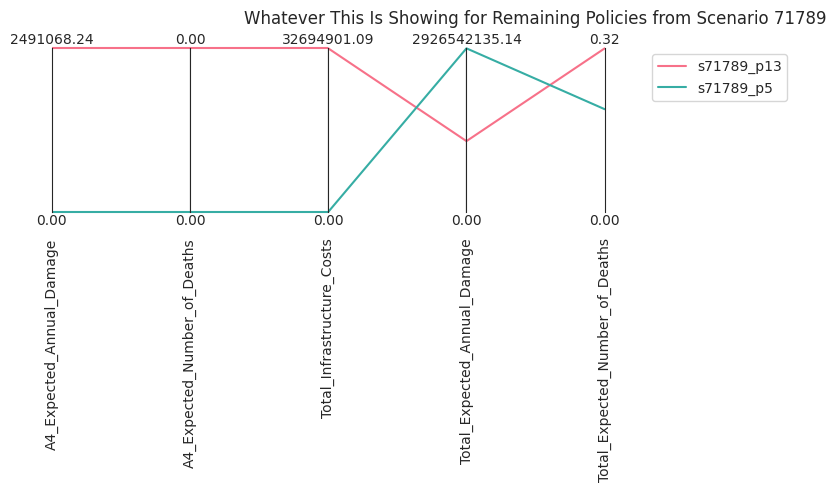

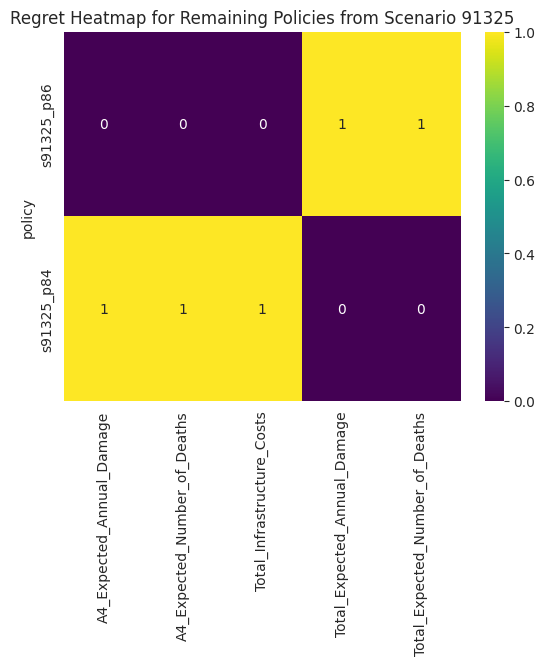

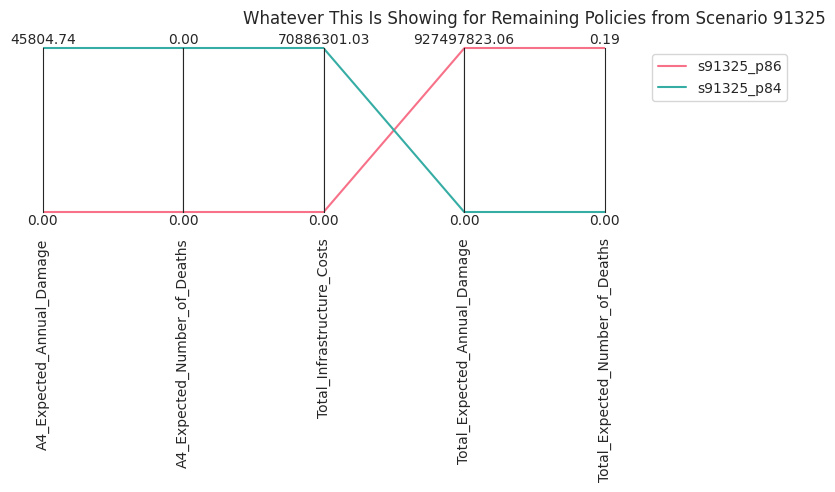

In [47]:
# generation of regret df

for scenario in scenarios:
    if len(nondominated_policies[scenario]) < 2:
        continue

    all_regrets = {}
    max_regret = {}
    for outcome in model.outcomes:
        experiments_df = experiments_by_scenario[scenario]
        outcomes_dict = outcomes_by_scenario[scenario]
        # create a DataFrame with all the relevent information
        # i.e., policy, scenario_id, and scores
        data = pd.DataFrame({
            outcome.name : outcomes_dict[outcome.name], 
            "policy" : experiments_df['policy'],
            "robustness_scenario" : experiments_df['scenario'],
        })
        
        # Filter out rows that are not for policies kept according to signal to noise ratio. 
        data = data[data['policy'].isin(nondominated_policies[scenario])]

        # reorient the data by indexing with policy and scenario id
        data = data.pivot(index='robustness_scenario', columns='policy')
        
        # flatten the resulting hierarchical index resulting from 
        # pivoting, (might be a nicer solution possible)
        data.columns = data.columns.get_level_values(1)

        # we need to control the broadcasting. 
        # max returns a 1d vector across scenario id. By passing
        # np.newaxis we ensure that the shape is the same as the data
        # next we take the absolute value
        #
        # basically we take the difference of the maximum across 
        # the row and the actual values in the row
        #
        outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
        
        all_regrets[outcome.name] = outcome_regret
        max_regret[outcome.name] = outcome_regret.max()

    # plotting regret heatmap
    max_regret = pd.DataFrame(max_regret)
    sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
    plt.title(f'Regret Heatmap for Remaining Policies from Scenario {scenario}')
    plt.show()
    # Max regret visualisation

    # TODO: set the number of colors to the number of policies for best visualisation. sns.color_palette() has less 10 colors.
    colors = sns.color_palette("husl", len(nondominated_policies[scenario]))

    data = max_regret

    limits = parcoords.get_limits(data)
    limits.loc[0, outcomes_of_interest] = 0

    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    paraxes.legend()
    plt.title(f'Whatever This Is Showing for Remaining Policies from Scenario {scenario}')
        
    plt.show()

**TODO**: Have to then further filter "nondominated_policies" from 7 total to 3, maybe based on the values here. Perhaps we could compare the "regret" scores across scenario lines instead of separated by scenario? I don't have enough of a grasp on what the scenarios mean to determine that.